Survival analysis is an important concept with lots of relevance in Business

Some examples of application include:
- SaaS providers are interested in measuring subscriber lifetimes, or time to some first action
- inventory stock out is a censoring event for true "demand" of a good.
- sociologists are interested in measuring political parties' lifetimes, or relationships, or marriages
- A/B tests to determine how long it takes different groups to perform an action.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve 
from sklearn.metrics import brier_score_loss
#! pip install lifelines==0.26.4
!pip install lifelines
import lifelines


In [16]:
data = pd.read_csv('/Users/school/WA_Fn-UseC_-Telco-Customer-Churn.csv')


In [17]:
pd.set_option('display.max_columns', None)
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [18]:
# we see that the 488 row is a space
data.loc[488,'TotalCharges']

' '

In [19]:
# We wish to drop customerID and total charges from the main DF as it relates to identifiability and multicollineraity issue

churned_customers = data[data['Churn'] == 'No']
customerID = pd.DataFrame(churned_customers[['customerID', 'MonthlyCharges']])
data.drop(columns = ['customerID' , 'TotalCharges'], inplace=True)



# Note the white space problem above, we need to replace single whitespace and convert to numeric
data['MonthlyCharges'] = pd.to_numeric(data['MonthlyCharges'])
data['TotalCharges'].replace(' ', np.nan, inplace=True)
data.dropna(subset=['TotalCharges'], inplace=True)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])


# We will also create a copy of DF that will be utilised later to plot categorical KM Curves
data_kmf = data.copy()


In [20]:
# Convert Churn column to 1 (Yes) or 0 (No)
data['Churn'] = data['Churn'].replace({"No": 0, "Yes": 1})

Note that some features has 3 categories: Yes, No and No phone service, for our purpose we can treat no phone service as just No.

In [21]:
# List of features to assign 1 to if original value is yes and 0 otherwise
features_to_combine = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
   'TechSupport', 'StreamingTV', 'StreamingMovies']

# Assign 1 to Yes and 0 otherwise
for feat in features_to_combine:
    data[feat] = data[feat].apply(lambda x: 1 if x == 'Yes' else 0)

In [22]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,Female,0,Yes,No,1,No,0,DSL,0,1,0,0,0,0,Month-to-month,Yes,Electronic check,29.85,0
1,Male,0,No,No,34,Yes,0,DSL,1,0,1,0,0,0,One year,No,Mailed check,56.95,0
2,Male,0,No,No,2,Yes,0,DSL,1,1,0,0,0,0,Month-to-month,Yes,Mailed check,53.85,1
3,Male,0,No,No,45,No,0,DSL,1,0,1,1,0,0,One year,No,Bank transfer (automatic),42.30,0
4,Female,0,No,No,2,Yes,0,Fiber optic,0,0,0,0,0,0,Month-to-month,Yes,Electronic check,70.70,1


We can create dummy variables for the remaining categorical variables like Phone service, Contract...

Note that in the pd.get_dummies, we set drop_first to False. This change is intentional so that we can mannually control what we want to set as the baseline model. This choice is made for better understanding of the business case and model


In [23]:
# manipulating categorical var, note that we do not drop_first here because we want to specifically control
data = pd.get_dummies(data, columns = ['gender', 'Partner', 'Dependents', 'PhoneService',
                     'InternetService', 'Contract', 'PaperlessBilling',
                        'PaymentMethod'], drop_first = False)

In [24]:
# Here we mannualy specify what the business considers to be typical of their subscribers
data.drop(columns = ['gender_Male', 'Partner_Yes', 'Dependents_No', 'PhoneService_Yes',
   'InternetService_Fiber optic', 'Contract_Month-to-month', 'PaperlessBilling_Yes',
    'PaymentMethod_Electronic check'], inplace = True)

In [25]:
data.head()

,SeniorCitizen,tenure,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MonthlyCharges,Churn,gender_Female,Partner_No,Dependents_Yes,PhoneService_No,InternetService_DSL,InternetService_No,Contract_One year,Contract_Two year,PaperlessBilling_No,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Mailed check
0,0,1,0,0,1,0,0,0,0,29.85,0,1,0,0,1,1,0,0,0,0,0,0,0
1,0,34,0,1,0,1,0,0,0,56.95,0,0,1,0,0,1,0,1,0,1,0,0,1
2,0,2,0,1,1,0,0,0,0,53.85,1,0,1,0,0,1,0,0,0,0,0,0,1
3,0,45,0,1,0,1,1,0,0,42.30,0,0,1,0,1,1,0,1,0,1,1,0,0
4,0,2,0,0,0,0,0,0,0,70.70,1,1,1,0,0,0,0,0,0,0,0,0,0


Let's first visualize the continous variables between churned and non churned customers

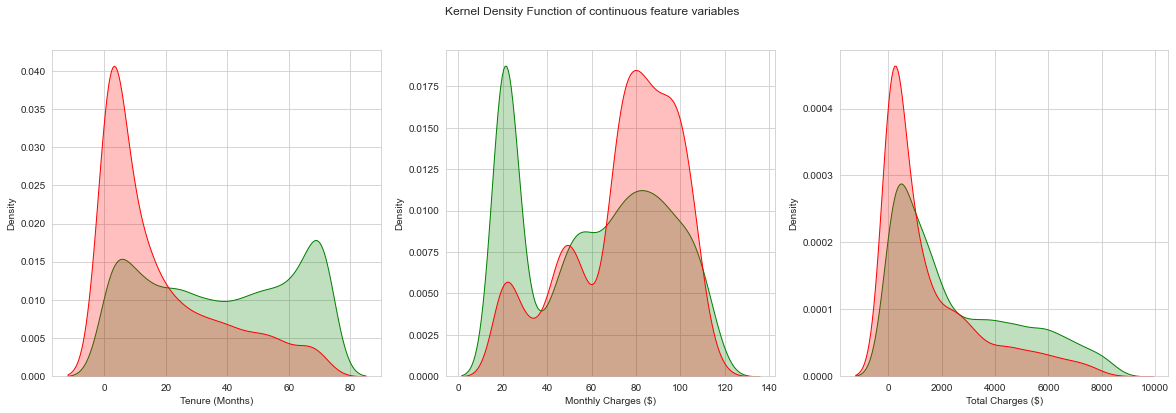

In [12]:
sns.set_style('whitegrid')
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,6))
fig.suptitle("Kernel Density Function of continuous feature variables")
# tenure
sns.kdeplot(data['tenure'].loc[data['Churn'] == 0], label='not churn', shade=True, ax = ax1, color = 'green')
sns.kdeplot(data['tenure'].loc[data['Churn'] == 1], label='churn', shade=True, ax = ax1, color = 'red')
ax1.set_xlabel("Tenure (Months)")
# monthly charges
sns.kdeplot(data['MonthlyCharges'].loc[data['Churn'] == 0], label='not churn', shade=True, ax = ax2,color = 'green')
sns.kdeplot(data['MonthlyCharges'].loc[data['Churn'] == 1], label='churn', shade=True, ax = ax2,color = 'red')
ax2.set_xlabel("Monthly Charges ($)")
# total charges
sns.kdeplot(data['TotalCharges'].loc[data['Churn'] == 0], label='not churn', shade=True, ax = ax3,color = 'green')
sns.kdeplot(data['TotalCharges'].loc[data['Churn'] == 1], label='churn', shade=True, ax = ax3,color = 'red')
ax3.set_xlabel("Total Charges ($)");

We see from the first plot 
- that the churned customers are usually those who are new to the service
- It could be that these customers change service provider frequently to negogiate better deal

We see from the second plot 
- those who churn tend to have higher charges

From the third plot
- we see similar phenomenon in the first plot, this might be due to total charges is a proxy with tenure

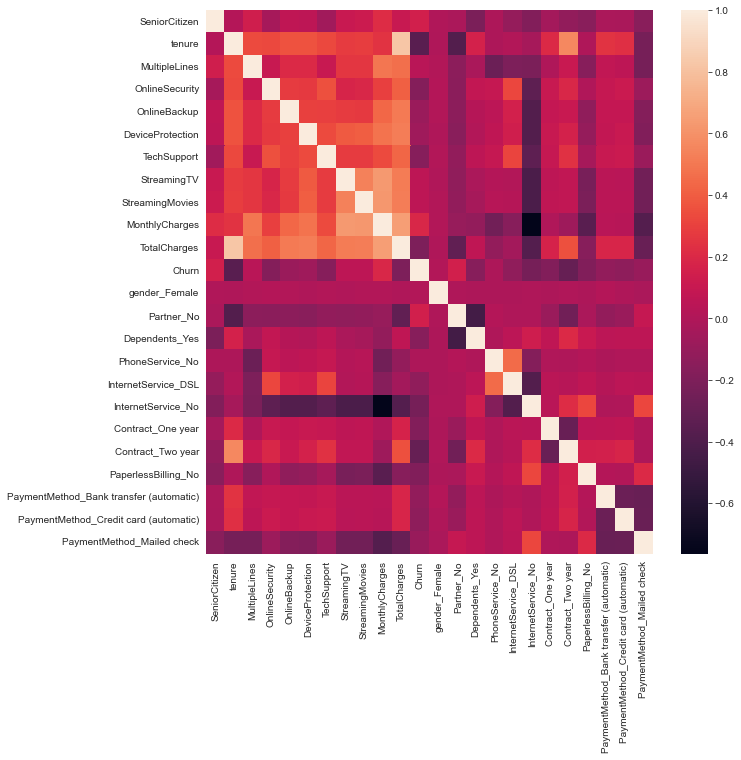

In [14]:
# Let's check for multicollinearity as it is a basic assumption of the CPH model
fig = plt.figure(figsize=(10,10))
corrmat = data.corr()
sns.heatmap(corrmat);

Setting up data for futher analysis

In [26]:
# Update Churn column of data_kmf that we kept aside for this moment before feature engineering
data_kmf['Churn'] = data_kmf['Churn'].replace({"No": 0, "Yes": 1})

In [27]:
# save indices for each contract type
idx_m2m = data_kmf['Contract'] == 'Month-to-month'
idx_1y = data_kmf['Contract'] == 'One year'
idx_2y = data_kmf['Contract'] == 'Two year'

In [28]:

T1 = data_kmf.loc[idx_m2m, 'tenure']
T2 = data_kmf.loc[idx_1y, 'tenure']
T3 = data_kmf.loc[idx_2y, 'tenure']
E1 = data_kmf.loc[idx_m2m, 'Churn']
E2 = data_kmf.loc[idx_1y, 'Churn']
E3 = data_kmf.loc[idx_2y, 'Churn']




# The Kaplan _Meier Survival Curve

The survival curve or survival function is defined as 
$$ S(t) = Pr(T > t) $$

To exemplify the equation, in this example, the company is interested in modelling customer churn. Let T measure the time that a customer cancels their subscription. At any given time T = t, S(t) will be the probability that a customer cancels later time t. The higher the probability, the less likely the customer has churned before time t.

However as with most things in Statistics, we do not know the true statistical model and hence the best thing we can do is have a good estimation of the true distribution.

The Kaplan Meier is a method to estimate the survival curve.


For the purpose of the business case, I suspect that the contract type plays a major factor in predicting churn of a customer. We will group the customers by their contract type: 3 months, 1 year and 2 years respectively.

I have ommited the math but interested readers should go to "An introduction to Statistical Learning" Chp 11 by James, Hastie, Tibshirani et.al

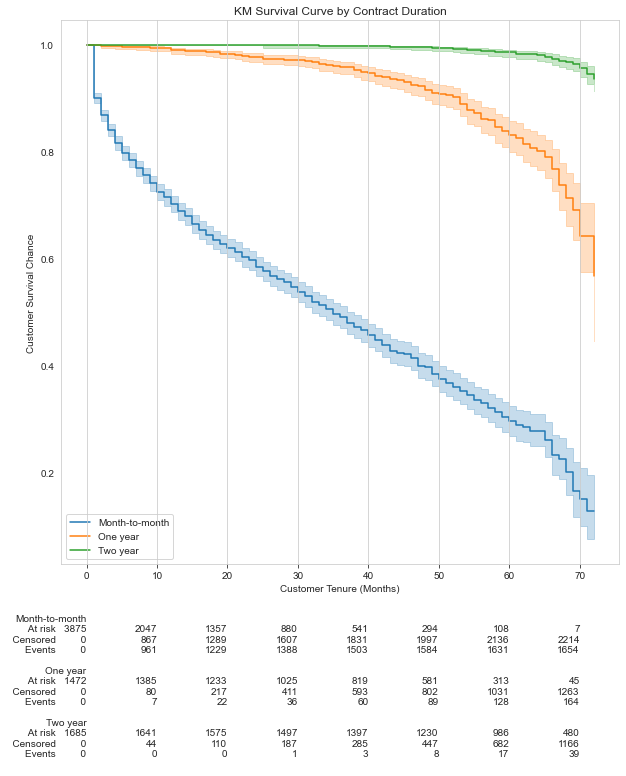

In [29]:
# Update Churn column of data_kmf that we kept aside for this moment before feature engineering
data_kmf['Churn'] = data_kmf['Churn'].replace({"No": 0, "Yes": 1})

# plot the 3 KM plots for each category
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10,10))
kmf_m2m = lifelines.KaplanMeierFitter()
ax = kmf_m2m.fit(durations = T1, event_observed = E1, label = 'Month-to-month').plot(ax = ax)
kmf_1y = lifelines.KaplanMeierFitter()
ax = kmf_1y.fit(durations = T2, event_observed = E2, label = 'One year').plot(ax = ax)
kmf_2y = lifelines.KaplanMeierFitter()
ax = kmf_2y.fit(durations = T3, event_observed = E3, label = 'Two year').plot(ax = ax)

# display title and labels
ax.set_title('KM Survival Curve by Contract Duration')
ax.set_xlabel('Customer Tenure (Months)')
ax.set_ylabel('Customer Survival Chance')
plt.grid()

# display at-risk counts for each category
lifelines.plotting.add_at_risk_counts(kmf_m2m, kmf_1y, kmf_2y, ax = ax);

From the Kaplan Meier estimation of the survival curve, it seems like customers who are on a month to month contract churns the most, one year is in the middle while 2 year contracts really locks in the customer and we can see that by the end of 1 year, most of the 2-yeared contract customers are still with the company.

We have also incorporated the 5% standard error bands for each survival curve and we can reasonably say that the three groups have different survival curve without doing further work.

However, what if we want to have a formal test of equality of the 3 survival curves ? We would need the Log-Rank test.


# Log-Rank test

To be sucinct, Log-rank test is borrows idea from 2-sample t-test, but due to the censoring nature of the observations,we have to somehow incorporate information as to how the events in each group unfold sequentially over time.

In [30]:
from lifelines.statistics import logrank_test
results = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)


In [31]:
print(len(T1),len(T2),len(T3))

3875 1472 1685


In [32]:
results.print_summary()
print(results.p_value)        
print(results.test_statistic)

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         926.06 <0.005    673.27

2.1173266936012146e-203
926.0645586243704


In [ ]:
#from lifelines.statistics import multivariate_logrank_test



Since the p-value is less than 0.005 we reject the Null hypothesis. This suggests there is evidence against 
the 2 contract types ignoring other factors. Those with a month to month seems to have shorter survival time 
than the 1 year contract, ignoring other factors.

However there are several limitations:

1) we can't test multiple hypothesis at the same time 

2) we simply can't account for confounders or have continous variable. 

3) Also since KM is non-parametric we can't summarize the relationship with a number/ coefficient. We would require
the below graph to express the relationship.

KM is only a good initial starting point, to really address for confounders and to create something with
more predictive power we move next to the CPHM

# Cox Proportional Hazards Model with cross validated model

Quick primer:
its another type of regression model, we can incorporate numeric explanatory variables, non parametric, doesn't assume constant hazard

recall the harzard means the probability you die now given you are alive, for practicaliy you can think of it as the probability you will die the next milisecond. It is not really a useful concept on its own, however it is used in the mathematical formulation.

Cox has log base line hazard, unspecified, it is allowed to vary over time, note that we also do not know what the base line hazard is so this model can't be used to predict someone's hazard at a particular time , like you would want to use a linear regression model to predict Y.

what we can do is estimate the hazard ratio, to compare between 2 groups.

In [34]:
# Instantiate and fit CPH model
cph = lifelines.CoxPHFitter(alpha= 0.01)
cph.fit(data, duration_col = 'tenure', event_col = 'Churn')

# Print model summary
cph.print_summary(model = 'base model', decimals = 3, columns = ['coef', 'exp(coef)', 'p']) 

# the Cross validated goodness of fit:
#k_fold_cross_validation(cph, data, duration_col='tenure', event_col='Churn', scoring_method="concordance_index")
lifelines.utils.k_fold_cross_validation(cph, data, 'tenure', 'Churn', k = 10, scoring_method = 'concordance_index')

/Users/school/opt/anaconda3/lib/python3.8/site-packages/lifelines/utils/printer.py:74: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  columns = summary_df.columns & self.columns
/Users/school/opt/anaconda3/lib/python3.8/site-packages/lifelines/utils/printer.py:61: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  columns = summary_df.columns & self.columns


<lifelines.CoxPHFitter: fitted with 7032 total observations, 5163 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7032
number of events observed = 1869
   partial log-likelihood = -13884.601
         time fit was run = 2022-02-26 01:40:13 UTC
                    model = base model

---
                                          coef  exp(coef)       p
covariate                                                        
SeniorCitizen                           -0.071      0.931   0.208
MultipleLines                           -0.418      0.658   0.001
OnlineSecurity                          -0.612      0.542 <0.0005
OnlineBackup                            -0.613      0.542 <0.0005
DeviceProtection                        -0.283      0.754   0.024
TechSupport                             -0.369      0.691   0.005
StreamingTV                              0.041      1.042   0.862
StreamingMovies                         -0.054      0.948   0.819
MonthlyCharges                          -0.008      0.992   0.726
gender_Female                            0.085      1.089   0.066
Partner_No                               0.518      1.679 <0.0005
Dependents_Yes                          -0.054      0.948   0.434
PhoneService_No                         -0.255      0.775   0.589
InternetService_DSL                     -0.587      0.556   0.308
InternetService_No                      -1.888      0.151   0.101
Contract_One year                       -1.615      0.199 <0.0005
Contract_Two year                       -3.232      0.039 <0.0005
PaperlessBilling_No                     -0.181      0.834   0.001
PaymentMethod_Bank transfer (automatic) -0.586      0.557 <0.0005
PaymentMethod_Credit card (automatic)   -0.670      0.512 <0.0005
PaymentMethod_Mailed check              -0.020      0.980   0.782
---
Concordance = 0.866
Partial AIC = 27811.201
log-likelihood ratio test = 3536.878 on 21 df
-log2(p) of ll-ratio test = inf

[0.861077570733936,
 0.8579942411999733,
 0.8599106408264009,
 0.8674285457183672,
 0.8823320899592086,
 0.8496108217757468,
 0.8625374061317825,
 0.8749943648002885,
 0.8695255686438512,
 0.8556799346063895]

# Interpreting the model

the column 'coef' is the coefficient of each variable on risk.

The higher the coef, the more likely the feature is to contribute to churn

the column 'exp(coef)' is the hazard ratio. Note that this ratio is a comparison between 2 groups. The numerator represents the group of interest, while the demonominator represents the baseline group. For example if the hazard ratio for 'InternetService_N' is 0.035, this implies a customer who does not have internet service is 0.035 as likely to cancel their subscription compared to the base line (with internet service)

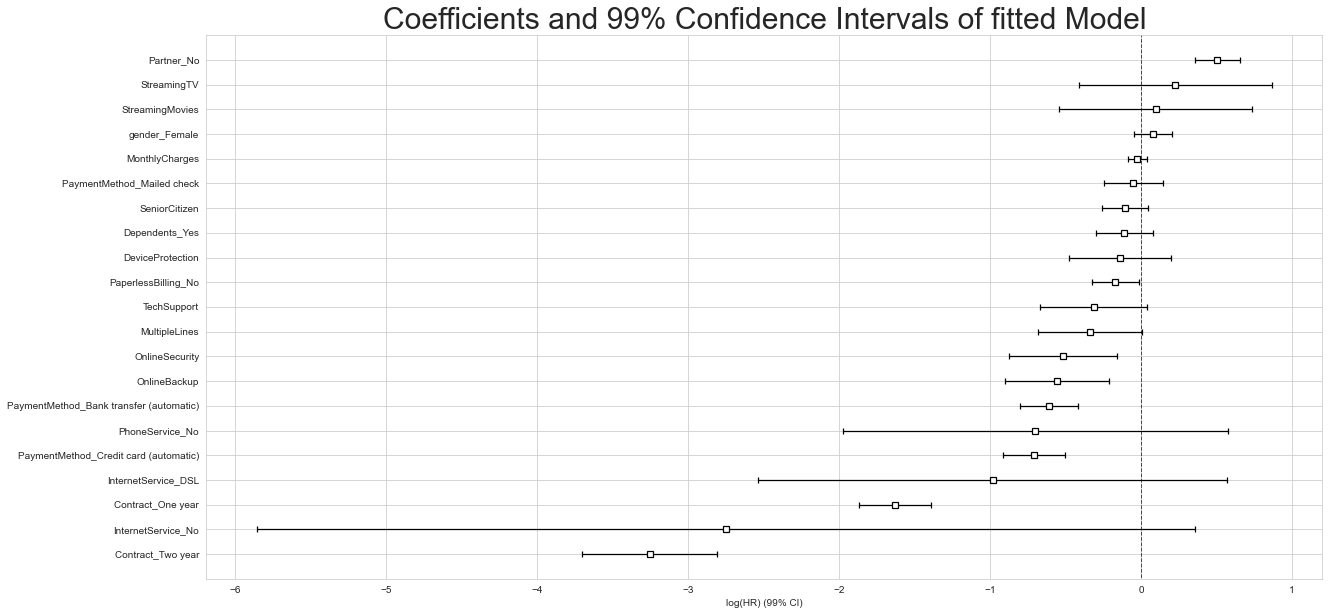

In [35]:
# Plotting the coefficients
fig_coef, ax_coef = plt.subplots(figsize = (20,10))

ax_coef.set_title('Coefficients and 99% Confidence Intervals of fitted Model', fontsize=30)
cph.plot(ax = ax_coef);

The above plot shows which characterisitics are likely to be correlated to churn is 
1) having no Partner

while those who are not likely to churn:
- contract_two year
- contract_one year
- automatic bank transfer payment
- using credit card to pay
- using paper billing

Note that InternetService No has a really large confidence interval hence we retain from including it in the list


# Monthly charges effect on survival

Here we can plot the partial effect of monthly charges on the outcome of the survival curve. It is not suprising to see that customers with higher monthly charges tends to churn more than those with lower charges.

There will be an interesting optimization problem as to setting the correct monthly prices for each specific customer to maximize revenue. 


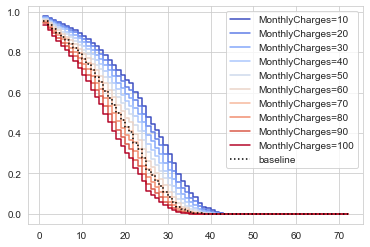

In [96]:
cph.plot_partial_effects_on_outcome(covariates='MonthlyCharges', values=[10, 20,30,40,50,60,70,80,90,100], cmap='coolwarm')

# Prediction:

Predict the survival function for individuals, given their covariates. This assumes that the individual just entered the study (that is, we do not condition on how long they have already lived for.)

In [97]:
# first filter for 'alive' customers
censored_data = data[data['Churn'] == 0]
# remove the tenure column as we do not want to condition on this variable
censored_data_last_obs = censored_data['tenure']
# Predict the survival function for each customer using the explanatory variables, from this time point on
conditioned_sf = cph.predict_survival_function(censored_data, conditional_after = censored_data_last_obs)
conditioned_sf

0             1         3              6              7     \
1.0    9.865287e-01  9.821800e-01  0.980593   9.584022e-01   9.870164e-01   
2.0    9.733905e-01  9.670089e-01  0.956018   8.981427e-01   9.684255e-01   
3.0    9.602823e-01  9.402829e-01  0.942409   8.077974e-01   9.493901e-01   
4.0    9.465329e-01  9.124417e-01  0.908845   7.594965e-01   9.326578e-01   
5.0    9.362754e-01  8.944037e-01  0.881442   7.107693e-01   9.063390e-01   
...             ...           ...       ...            ...            ...   
68.0  2.039518e-130  9.920619e-18  0.000098  1.202735e-227  1.049658e-216   
69.0  3.765787e-181  9.920619e-18  0.000098  1.202735e-227  1.049658e-216   
70.0  1.821399e-231  9.920619e-18  0.000098  1.202735e-227  1.049658e-216   
71.0   0.000000e+00  9.920619e-18  0.000098  1.202735e-227  1.049658e-216   
72.0   0.000000e+00  9.920619e-18  0.000098  1.202735e-227  1.049658e-216   

          9         10        11        12             14        15    \
1.0   0.984968  0.973050  0.999902  0.995536   9.579725e-01  0.999763   
2.0   0.962484  0.931183  0.999790  0.988936   9.147429e-01  0.999528   
3.0   0.911304  0.895397  0.999686  0.982108   8.672213e-01  0.999073   
4.0   0.858330  0.857477  0.999574  0.974109   8.032162e-01  0.999073   
5.0   0.793681  0.815908  0.999493  0.968815   7.382433e-01  0.999073   
...        ...       ...       ...       ...            ...       ...   
68.0  0.238641  0.000000  0.177488  0.581734  1.097364e-158  0.999073   
69.0  0.238641  0.000000  0.177488  0.581734  1.097364e-158  0.999073   
70.0  0.238641  0.000000  0.177488  0.581734  1.097364e-158  0.999073   
71.0  0.238641  0.000000  0.177488  0.581734  1.097364e-158  0.999073   
72.0  0.238641  0.000000  0.177488  0.581734  1.097364e-158  0.999073   

          16        17        19            21        23        24    \
1.0   0.936380  0.998634  0.876950  9.992553e-01  0.998537  0.970837   
2.0   0.864369  0.998634  0.805678  9.985888e-01  0.996365  0.948106   
3.0   0.830677  0.998634  0.707775  9.975167e-01  0.994108  0.921858   
4.0   0.753046  0.998634  0.572844  9.965623e-01  0.991450  0.873500   
5.0   0.702613  0.998634  0.506541  9.955096e-01  0.989683  0.818041   
...        ...       ...       ...           ...       ...       ...   
68.0  0.000023  0.998634  0.000000  7.863125e-09  0.837504  0.000146   
69.0  0.000023  0.998634  0.000000  7.863125e-09  0.837504  0.000146   
70.0  0.000023  0.998634  0.000000  7.863125e-09  0.837504  0.000146   
71.0  0.000023  0.998634  0.000000  7.863125e-09  0.837504  0.000146   
72.0  0.000023  0.998634  0.000000  7.863125e-09  0.837504  0.000146   

              25    28        30        31            32            33    \
1.0   9.579124e-01   1.0  0.998488  0.824609  9.954011e-01  9.981024e-01   
2.0   8.978861e-01   1.0  0.998488  0.678504  9.888288e-01  9.962301e-01   
3.0   8.533327e-01   1.0  0.998488  0.551395  9.816483e-01  9.943403e-01   
4.0   8.182680e-01   1.0  0.998488  0.471407  9.725957e-01  9.923341e-01   
5.0   7.653654e-01   1.0  0.998488  0.372587  9.591288e-01  9.908210e-01   
...            ...   ...       ...       ...           ...           ...   
68.0  5.114296e-64   1.0  0.998488  0.000000  2.265442e-14  6.878211e-19   
69.0  5.114296e-64   1.0  0.998488  0.000000  2.265442e-14  5.400944e-26   
70.0  5.114296e-64   1.0  0.998488  0.000000  2.265442e-14  4.853262e-33   
71.0  5.114296e-64   1.0  0.998488  0.000000  2.265442e-14  1.123632e-46   
72.0  5.114296e-64   1.0  0.998488  0.000000  2.265442e-14  1.123632e-46   

               34    35            37             40        41    \
1.0    9.745510e-01   1.0  9.203096e-01   9.930737e-01  0.995594   
2.0    9.500311e-01   1.0  8.781337e-01   9.830813e-01  0.987124   
3.0    9.258624e-01   1.0  7.798801e-01   9.727565e-01  0.987124   
4.0    9.008289e-01   1.0  7.055443e-01   9.636007e-01  0.987124   
5.0    8.823647e-01   1.0  6.511759e-01   9.490420e-01  0.987124   
...             ...   ...  

In the above table, the 72 rows, represent the number of months from today's time, while the columns represent each individual customers who are still with the company, as you see for each customer, as the month passes, it is more likely for them to churn and leave the company.

Note that if we want to interpret on what month will a customer cancel their plans with the company, we need to set a threshold where if the probability passing the threshold implies the customer has churned. 

Out of all the thresholds, the median would be the more robust to outlier and is a representative attribute for this business context.

For now, let's set the threshold to the median

In [100]:
pred_50 = lifelines.utils.qth_survival_times(0.5, conditioned_sf)
pred_50


0     1     3     6     7     9     10    11    12    14    15    16    \
0.9   8.0   5.0   5.0   2.0   6.0   4.0   3.0  41.0   9.0   3.0   inf   2.0   

     17    19    21    23    24    25    28    30    31    32    33    34    \
0.9   inf   1.0  27.0  13.0   4.0   2.0   inf   inf   1.0  10.0  23.0   5.0   

     35    37    40    41    42    43    44    45    46    48    49    50    \
0.9   inf   2.0   9.0   inf  21.0   inf   4.0   1.0   3.0  20.0   inf   3.0   

     52    54    56    57    58    59    60    61    62    63    65    66    \
0.9   5.0   8.0   8.0   inf  31.0   inf   3.0   4.0   inf  11.0   2.0   4.0   

     67    68    69    70    71    72    73    74    75    76    77    78    \
0.9  20.0  16.0   2.0   3.0   2.0   inf   8.0   4.0  11.0   4.0   5.0   2.0   

     79    81    83    84    85    86    87    88    89    90    91    92    \
0.9   8.0   5.0   4.0  17.0   1.0   8.0  19.0  16.0   2.0   3.0   1.0   inf   

     93    94    96    98    100   101   102   103   105   106   107   108   \
0.9   5.0   inf   inf  15.0  18.0  22.0   8.0   1.0   6.0   inf   5.0   4.0   

     109   111   112   114   115   116   118   119   120   121   123   124   \
0.9   inf   5.0   3.0   7.0   1.0  19.0  18.0   3.0  10.0  16.0   5.0  19.0   

     125   127   128   129   130   132   135   136   137   138   140   142   \
0.9  20.0   inf  18.0   1.0   2.0   4.0  22.0   2.0   5.0   9.0   inf   inf   

     143   144   145   146   148   149   150   152   153   154   155   156   \
0.9   5.0   inf   inf  28.0   8.0   3.0   2.0   inf   inf  18.0   2.0   2.0   

     157   158   159   160   162   163   164   165   167   169   170   172   \
0.9  17.0  24.0  44.0   4.0   1.0  17.0  24.0   2.0   inf  13.0   8.0  23.0   

     174   175   178   179   181   183   186   187   188   189   190   192   \
0.9  12.0   4.0   2.0   3.0   3.0  10.0   3.0   7.0  22.0   3.0  10.0   3.0   

     193   194   195   196   197   198   199   200   201   202   203   204   \
0.9   inf  10.0   3.0  35.0   6.0   inf  19.0   8.0   2.0   inf   2.0   2.0   

     205   206   209   211   212   213   214   215   216   217   218   219   \
0.9   7.0   inf   8.0   8.0   6.0  13.0   2.0   2.0   inf   inf   inf   1.0   

     221   222   224   225   226   228   229   230   231   233   234   236   \
0.9   inf  31.0  24.0   7.0   8.0   2.0  25.0   inf   5.0   inf   6.0  28.0   

     237   239   240   241   242   243   244   245   246   249   250   253   \
0.9   2.0  36.0   inf   inf  10.0   3.0   3.0   2.0   3.0   8.0   7.0   9.0   

     254   255   256   257   259   262   263   264   265   266   267   269   \
0.9  13.0   inf   inf  17.0   3.0   2.0  24.0  11.0   inf  16.0   2.0   inf   

     271   273   277   278   279   280   281   282   283   285   286   291   \
0.9  13.0   2.0   4.0   3.0   5.0   4.0   3.0  17.0   1.0   6.0   2.0   6.0   

     292   293   294   295   296   297   298   300   302   303   304   305   \
0.9   6.0   1.0  13.0  18.0   inf   2.0   2.0   7.0   1.0   inf   2.0  14.0   

     307   308   309   310   311   312   313   315   316   319   321   322   \
0.9  20.0   3.0   7.0  21.0   2.0  27.0   2.0  17.0   1.0   3.0   inf   3.0   

     323   324   325   326   328   329   330   331   332   337   338   340   \
0.9  10.0   inf   4.0   1.0   2.0   2.0  23.0  23.0   8.0   inf   3.0   4.0   

     341   342   343   344   345   347   348   349   350   351   352   356   \
0.9   inf   2.0   2.0   8.0   1.0   2.0   2.0   inf  24.0   7.0   1.0   3.0   

     357   359   360   361   362   363   364   366   367   368   369   370   \
0.9   inf   7.0  17.0  21.0   3.0  13.0   3.0   4.0  18.0   inf   inf  10.0   

     372   373   374   375   376   378   379   380   382   384   387   388   \
0.9  24.0  12.0   4.0  10.0   7.0   inf   5.0   6.0   inf  22.0   6.0   2.0   

     389   390   391   392   393   394   395   396   398   399   400   401   \
0.9   4.0   2.0   4.0   3.0   9.0   2.0   inf   5.0   2.0  16.0  11.0  27.0   

     403   404   405   406   4

With that the company can more concretly pinpoint when each customer is going to churn, this leads to a lot of future business strategies for customer retention. 

Note that the management can also play with the quantile, we can set it to the 90th quantile as a threshold if we want to get a 'warning' sign that a customer is thinking of leaving. There really isn't much you can do/ there will already be irreversible loss if you wait till the customer have already left before doing anything.